In [28]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
%matplotlib inline

In [9]:
def clean_raw(bc_full_df):
    import numpy as np
    import pandas as pd
    import pandas as pd
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    %matplotlib inline

    #alsways drop these cols
    bc_full_df = bc_full_df.drop('Worksheet Filter',axis=1)
    bc_full_df = bc_full_df.drop('Measure Display',axis=1)
    bc_full_df = bc_full_df.drop('Number of Records',axis=1)
    bc_full_df = bc_full_df.drop('Unnamed: 0',axis=1)
    bc_full_df = bc_full_df.drop('State',axis=1)
    bc_full_df = bc_full_df.drop('Table Id',axis=1)
    bc_full_df = bc_full_df.drop('Period Duration',axis=1)
    bc_full_df = bc_full_df.drop('Period Begin',axis=1)
    
    #drop when doing neighborhoods
#     bc_full_df = bc_full_df.drop('months_of_supply',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_yoy',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_mom',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Yoy',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Mom',axis=1)

    #lgo transforms of two variables so I can potentially use the additive decomposition
    bc_full_df['Inventory'] = np.log(bc_full_df['Inventory'])
    bc_full_df['months_of_supply'] = np.log(bc_full_df['months_of_supply'])


    #rename months_of_supply
    bc_full_df.rename(columns = {'months_of_supply': 'Months of Supply',
                                'months_of_supply_mom': 'Months of Supply Mom',
                                'months_of_supply_yoy': 'Months of Supply Yoy'}, inplace=True)

    #drop 2nd date col
    dates = ['Period End'] #dropped Period End
    for col in dates:
        bc_full_df[col] = pd.to_datetime(bc_full_df[col])
    
    #format percent cols
    percents = ['Median Sale Price Mom',
    'Median Sale Price Yoy',
    'New Listings Mom',
    'New Listings Yoy',
    'Homes Sold Mom',
    'Homes Sold Yoy',
    'Inventory Mom',
    'Inventory Yoy',
    'Avg Sale To List Mom',
    'Avg Sale To List Yoy']
    for col in percents:
        bc_full_df[col] = bc_full_df[col].str.strip('%')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
        
    #format money cols
    prices = ['Median Sale Price']
    for col in prices:
        bc_full_df[col] = bc_full_df[col].str.strip('$').str.strip('K').str.replace(',','')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
    
    #change scale
    bc_full_df['Median List Price'] = bc_full_df['Median List Price'] / 1000.0
    
    #set index
    bc_full_df = bc_full_df.sort_values('Period End')
    bc_full_df = bc_full_df.set_index('Period End')
    
    return bc_full_df

In [10]:
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [11]:
test_stationarity(differenced(bos['Median Dom']).values.ravel())

NameError: name 'differenced' is not defined

In [12]:
def decomp(series,trend=False,seas=False,resid=True,model='add'):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    df = pd.DataFrame()
    col_decomp = sm.tsa.seasonal_decompose(series, model=model,two_sided=False)
    #df[col] = col_decomp.observed
    if trend:
        df[series.name+' Trend'] = col_decomp.trend
    if seas:
        df[series.name+' Seasonal'] = col_decomp.seasonal
    if resid:
        df[series.name+' Residual'] = col_decomp.resid
    return df#, target_trend, target_seasonal

In [13]:
def diff(series,lag1=True,lag12=True):
    df = pd.DataFrame()
    lag = (series-series.shift(1)).dropna(axis=0)
    if lag1 and lag12:
        df[series.name+' Lag'] = (lag - lag.shift(12)).dropna()
    elif lag1:
        df[series.name+' Lag1'] = lag
    elif lag12:
        df[series.name+' Lag12'] = (series - series.shift(12)).dropna()
    return df

In [14]:
def read_data(df,reg_type='place'):
    #format data
    df = clean_raw(df)
    
    #create wide version of file
    #reg_type = 'place'
    rn_master_df = pd.DataFrame()
    for reg in [reg for reg in df[df['Region Type'] == reg_type]['Region'].unique()]:
        reg_df = df[df['Region'] == reg]
        #print('---'+reg)
        rn_reg_df = pd.DataFrame()
        for prop in [prop for prop in reg_df['Property Type'].unique()]:
            prop_df = reg_df[reg_df['Property Type'] == prop]
            rn_dict = {}
            #print('--'+prop)
            for col in [col for col in prop_df.columns if prop_df[col].dtype != 'object']:
                rn_dict[col] = reg+' '+prop+' '+col
                #print(reg+' '+prop+' '+col)
            prop_df = prop_df.rename(columns=rn_dict)
            prop_df = prop_df.drop([col for col in prop_df.columns if prop_df[col].dtype == 'object'],axis=1)
            rn_reg_df = pd.concat([rn_reg_df,prop_df],axis=1)
        rn_master_df = pd.concat([rn_master_df,rn_reg_df],axis=1)
        
    #drop 'object' columns from renamed master
    #rn_master_df = rn_master_df.drop([col for col in rn_master_df.columns if rn_master_df[col].dtype == 'object'],axis=1)
    
    return rn_master_df

In [15]:
def subset(df,term):
    import re
    return df[[col for col in df.columns if re.findall(term,col)]]

In [16]:
def plot(df,term,fig=(15,4)):
    #term = 'Median Sale Price'
    import re
    df[[col for col in df.columns if re.findall(term+'$',col)]].plot(figsize=fig)

In [17]:
#plot(df,'Single Family Residential Median Sale Price',(15,8))

In [18]:
#plot(df_combo,'Median Sale Price.+Residual')

# Comparison between the residuals of decomposition vs differencing
They seem to tell two different stories, maybe I should keep both?

In [19]:
# difference(bos['Median Dom']).plot()
# decomp(bos['Median Dom']).plot()

# test_stationarity(difference(df['Median Dom']).values.ravel())
# test_stationarity(decomp(df['Median Dom']).dropna().values.ravel())

In [20]:
def difference(df,cols,drop_orig=True):
    for col in cols:
        df = pd.concat([df,diff(df[col])],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    return df

In [21]:
def decompose(df,cols,drop_orig=True,resid=True,trend=False,seas=False):
    for col in cols:
        df = pd.concat([df,decomp(df[col],resid=resid,trend=trend,seas=seas)],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    #target_trend = decomp(df[col],resid=False,trend=True)
    #target_seas = decomp(df[col],resid=False,seas=True)
    return df#, target_trend, target_seas

In [22]:
def decompose_target(df,cols,drop_orig=True,resid=False,trend=True,seas=True):
    target_trend = decomp(df[col],resid=resid,trend=trend)
    target_seas = decomp(df[col],resid=resid,seas=seas)
    return pd.Series(target_trend), pd.Series(target_seas)

In [23]:
def scatter(df_combo,term):
    #term = 'Lag'
    import re
    import seaborn as sns
    fig, axes = plt.subplots(nrows=6, ncols=6)

    thing = [col for col in df_combo.columns if re.findall(term+'\\b',col)]

    for i, ax in enumerate(axes.reshape(-1)):
        df_combo.plot(x=[col for col in df_combo.columns if re.findall('Median Sale Price '+term+'\\b',col)][0]
                ,y=thing[i],kind='scatter',ax=ax,figsize=(18,18))

In [24]:
def create_supervised(df,term):    
    bos = df.copy()
    target = [col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,2):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True)    
    bos = bos.dropna(axis=0)
    return bos

In [25]:
# import pandas as pd
# import re
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# import seaborn as sns

# df = pd.read_csv('./bost_camb_full.csv')
# df = read_data(df)
# df = subset(df,'Boston, MA')
# #df = subset(df,'Townhouse')
# df = df.dropna(axis=1)
# df_decomp = decompose(df,df.columns)
# df_diff = difference(df,df.columns)
# df_combo = pd.concat([df_decomp,df_diff],axis=1)
# df_combo = df_combo.dropna(axis=0)

In [26]:
#plot(df_combo,'.+Median Sale Price Lag')
#plot(df_combo,'Median Sale Price Residual')

# Big Picture:
-Two channels
    - Supervised Learning to predict residuals
        - Data:
            - Function: create_supervised
            - Formats data to have next month's median sale price
            - Also lags all data by 13 months to allow predictive power
        - Models:
            - Trend/Seasonality Error Prediction (done)
            - ARMA Error Prediction (haven't done yet)
    - ARMA Model
        - Data:
            - Uses original pre-supervised data frame called df_orig
            - Haven't done any decomposition/differencing to it yet
        - Models:
            - Gridsearch
- Do ARMA before creating the supervised learning data, figure out the residual error, and imput into the supervised learning data to predict?

# Start Here:

Creates Dictionary of each Property Type Median Sale Price as Target variable, and df of top 10 correlations of each target variable

In [29]:
city = 'Boston, MA'

#pull fresh data
df = pd.read_csv('./bost_camb_full.csv')
df = read_data(df)
df = subset(df,city)
df = df.dropna(axis=1)
df_orig = df.copy()

#either decompose or diff, then clean up 
df = decompose(df,df.columns)
#df = decompose(df,df.columns)
#df = difference(df,df.columns)
df = df.dropna(axis=0)

#or both
# df_decomp = decompose(df,df.columns)
# df_diff = difference(df,df.columns)
# df_combo = pd.concat([df_decomp,df_diff],axis=1)
# df_combo = df_combo.dropna(axis=0)

#target variable - Remember its Lag or Residual if using diff/decomposition
term = 'Median Sale Price Residual'
city_dict = {}

#initilize
all_top_feat_df = pd.DataFrame()

#run loop for each property type
for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
    print(target_col)
    #top_feat_df = pd.DataFrame()
    df_super = create_supervised(df,target_col)
    top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                        list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))
    
    #collect top 10 corr per target
    top_feat_df = pd.DataFrame(top_feat)
    top_feat_df.columns = [target_col,target_col+' Corr']
    top_feat_df = top_feat_df.set_index(target_col)
    all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)
    
    #save each df_super in this dictionary, drop nan rows from lagging vars
    city_dict[target_col] = df_super

Boston, MA Single Family Residential Median Sale Price Residual
Boston, MA All Residential Median Sale Price Residual
Boston, MA Condo/Co-op Median Sale Price Residual
Boston, MA Townhouse Median Sale Price Residual



### Dictionary with dfs of each property type and target variable

In [269]:
#city_dict.keys()
#city_dict['Boston, MA Condo/Co-op Median Sale Price Residual']
#all_top_feat_df.fillna('')

# Supervised Learning, Residual Prediction: 
- I want to loop through each df in the dictionary
    - predict residual for each
    - save error of prediction

In [30]:
#city_dict.keys()
df = city_dict['Boston, MA Condo/Co-op Median Sale Price Residual']

target = 'Boston, MA Condo/Co-op Median Sale Price Residual T+1'
X = df.drop([target],axis=1)
y = df[target]

#timeseries split
tscv = TimeSeriesSplit(n_splits=4)

#timewise
split_date = '2016-01-31'
X_train = X[:split_date]
y_train = y[:split_date]
X_test = X[split_date:]
y_test = y[split_date:]

#holdout
# X, X_hold, y, y_hold = train_test_split(X,y,test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#model
#reg = BayesianRidge(n_iter=500)
#reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
reg = LinearSVR(C=.1, epsilon=5)
#reg = RandomForestRegressor(n_estimators=200)
#reg = LinearRegression()
#reg = ElasticNet(l1_ratio=.8)

#model fit
reg.fit(X_train,y_train)
y_pred_add = reg.predict(X_test)
score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
print(np.sqrt(-score).mean())

19.3742004575


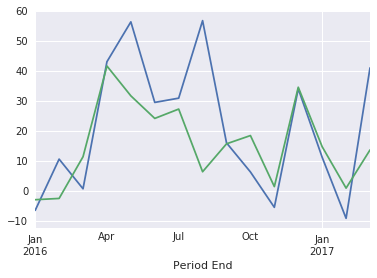

In [32]:
y_pred_add = pd.Series(y_pred_add)
y_pred_add.index = y_test.index
y_test.plot()#kind='bar')
y_pred_add.plot()#kind='bar')

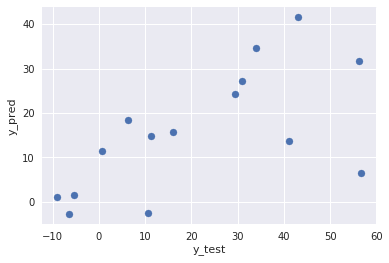

In [33]:
plt.scatter(y_test,y_pred_add)
plt.ylabel('y_pred')
plt.xlabel('y_test')

# Scoring/Prediction Error Functions:

In [51]:
def prediction_error(df,target,y_pred):
    y = df_orig[y_pred.index[0]:y_pred.index[-1]][target]
    return (y-y_pred).dropna()

In [52]:
def rmse_score(df,target,y_pred):
    y = df_orig[y_pred.index[0]:y_pred.index[-1]][target]
    return np.sqrt((y.values-y_pred)**2).sum()

In [53]:
print(r2_score(y_test,y_pred_add))
print(rmse_score(df_orig,'Boston, MA Condo/Co-op Median Sale Price',y_pred_add))

0.348649318618
8242.72038191


# Residual Prediction Model Coefs

In [284]:
#importance = pd.DataFrame(list(zip(X.columns,reg.feature_importances_)))
importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))

In [285]:
importance.columns = ['col','coef']

In [286]:
importance.sort_values(by='coef',ascending=False).head(10)

,col,coef
1762,"Boston, MA Townhouse Median Sale Price Residua...",0.028170
1669,"Boston, MA Townhouse Median List Price Residua...",0.024142
1668,"Boston, MA Townhouse Median List Price Residua...",0.022413
1855,"Boston, MA Townhouse New Listings Mom Residual...",0.022227
1753,"Boston, MA Townhouse Median Sale Price Residua...",0.021857
1861,"Boston, MA Townhouse New Listings Mom Residual...",0.020749
1667,"Boston, MA Townhouse Median List Price Residua...",0.018053
1678,"Boston, MA Townhouse Median List Price Residua...",0.017242
1720,"Boston, MA Townhouse Median Ppsf Residual T-12",0.016889
1761,"Boston, MA Townhouse Median Sale Price Residua...",0.015354


# Should I set mean to 0 for residuals? Are some models better at predicting values centered around 0 than floating ~20?

In [37]:
df

,"Boston, MA Single Family Residential Avg Sale To List Residual T-0","Boston, MA Single Family Residential Avg Sale To List Residual T-1","Boston, MA Single Family Residential Avg Sale To List Residual T-2","Boston, MA Single Family Residential Avg Sale To List Residual T-3","Boston, MA Single Family Residential Avg Sale To List Residual T-4","Boston, MA Single Family Residential Avg Sale To List Residual T-5","Boston, MA Single Family Residential Avg Sale To List Residual T-6","Boston, MA Single Family Residential Avg Sale To List Residual T-7","Boston, MA Single Family Residential Avg Sale To List Residual T-8","Boston, MA Single Family Residential Avg Sale To List Residual T-9",...,"Boston, MA Townhouse Sold Above List Yoy Residual T-5","Boston, MA Townhouse Sold Above List Yoy Residual T-6","Boston, MA Townhouse Sold Above List Yoy Residual T-7","Boston, MA Townhouse Sold Above List Yoy Residual T-8","Boston, MA Townhouse Sold Above List Yoy Residual T-9","Boston, MA Townhouse Sold Above List Yoy Residual T-10","Boston, MA Townhouse Sold Above List Yoy Residual T-11","Boston, MA Townhouse Sold Above List Yoy Residual T-12","Boston, MA Townhouse Sold Above List Yoy Residual T-13","Boston, MA Condo/Co-op Median Sale Price Residual T+1"
Period End,,,,,,,,,,,,,,,,,,,,,
2014-02-28,0.008697,0.017823,-0.001440,-0.000071,0.016912,0.009745,0.013339,0.008568,0.000842,0.005680,...,0.094446,0.148926,0.140360,0.128949,-0.011018,0.152079,0.067106,0.087931,0.067207,57.021528
2014-03-31,0.012781,0.008697,0.017823,-0.001440,-0.000071,0.016912,0.009745,0.013339,0.008568,0.000842,...,-0.153630,0.094446,0.148926,0.140360,0.128949,-0.011018,0.152079,0.067106,0.087931,12.813194
2014-04-30,-0.004209,0.012781,0.008697,0.017823,-0.001440,-0.000071,0.016912,0.009745,0.013339,0.008568,...,-0.086798,-0.153630,0.094446,0.148926,0.140360,0.128949,-0.011018,0.152079,0.067106,-10.040972
2014-05-31,-0.005684,-0.004209,0.012781,0.008697,0.017823,-0.001440,-0.000071,0.016912,0.009745,0.013339,...,-0.023913,-0.086798,-0.153630,0.094446,0.148926,0.140360,0.128949,-0.011018,0.152079,19.896528
2014-06-30,-0.012959,-0.005684,-0.004209,0.012781,0.008697,0.017823,-0.001440,-0.000071,0.016912,0.009745,...,-0.200484,-0.023913,-0.086798,-0.153630,0.094446,0.148926,0.140360,0.128949,-0.011018,7.865278
2014-07-31,0.003234,-0.012959,-0.005684,-0.004209,0.012781,0.008697,0.017823,-0.001440,-0.000071,0.016912,...,-0.041144,-0.200484,-0.023913,-0.086798,-0.153630,0.094446,0.148926,0.140360,0.128949,-14.759722
2014-08-31,-0.003841,0.003234,-0.012959,-0.005684,-0.004209,0.012781,0.008697,0.017823,-0.001440,-0.000071,...,0.086057,-0.041144,-0.200484,-0.023913,-0.086798,-0.153630,0.094446,0.148926,0.140360,3.219444
2014-09-30,-0.002873,-0.003841,0.003234,-0.012959,-0.005684,-0.004209,0.012781,0.008697,0.017823,-0.001440,...,-0.290227,0.086057,-0.041144,-0.200484,-0.023913,-0.086798,-0.153630,0.094446,0.148926,-8.145139
2014-10-31,-0.007085,-0.002873,-0.003841,0.003234,-0.012959,-0.005684,-0.004209,0.012781,0.008697,0.017823,...,0.083883,-0.290227,0.086057,-0.041144,-0.200484,-0.023913,-0.086798,-0.153630,0.094446,5.084028


In [43]:
# mean_resid_dict = {}
# for col in [col for col in df.columns if re.findall(r'Residual\b',col)]:
#     mean_resid_dict[col] = df[col].mean()
#     df[col] = df[col] - df[col].mean()

In [38]:
#target = 'Boston, MA Condo/Co-op Median Sale Price'
#mean_resid_dict['Boston, MA Condo/Co-op Median Sale Price Residual']

# The prediction must be shifted to align with the real forcast
Automate the omparison between the original target variable and the predicted residual variable (T+1)

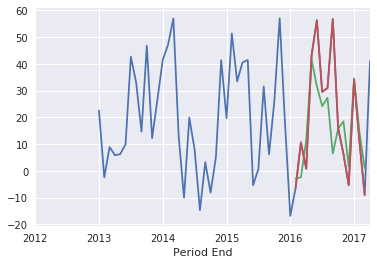

In [44]:
col_decomp = sm.tsa.seasonal_decompose(df_orig['Boston, MA Condo/Co-op Median Sale Price'],two_sided=False)
col_decomp.resid.plot()
y_pred_add.shift().plot()
y_test.shift().plot()

In [45]:
y_pred_trend_seas_perf = (col_decomp.trend
                         +col_decomp.seasonal
                         #+mean_resid_dict[target]
                         +y_test.shift())
y_pred_trend_seas_add = (col_decomp.trend
                         +col_decomp.seasonal
                         #+mean_resid_dict[target]
                         +y_pred_add.shift())
y_pred_trend_seas = (col_decomp.trend
                     +col_decomp.seasonal)
                     #+mean_resid_dict[target])
y_pred_trend = (col_decomp.trend)
                #+mean_resid_dict[target])
y_pred_trend = y_pred_trend.dropna()

# Plot Predictions vs True
Should put this in the same function as the plot ARIMA score too

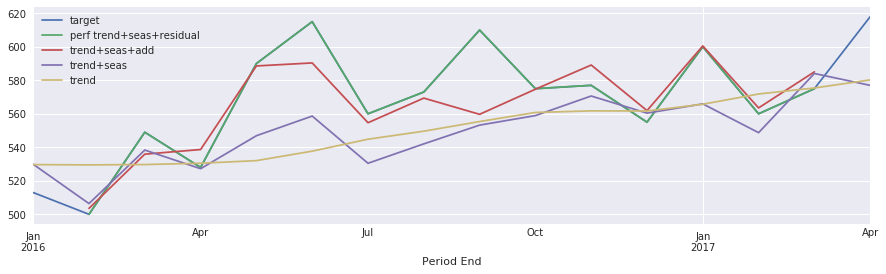

In [47]:
target = 'Boston, MA Condo/Co-op Median Sale Price'
labels=['target','perf trend+seas+residual','trend+seas+add','trend+seas','trend']
plt.figure()
df_orig['2016':][target].plot(figsize=(15,4))
ax = y_pred_trend_seas_perf['2016':].plot()
ax = y_pred_trend_seas_add['2016':].plot()
ax = y_pred_trend_seas['2016':].plot()
ax = y_pred_trend['2016':].plot()
ax.legend(labels=labels)

# Model RMSEs for Decompositions: 
### Trend, Trend+Seasonality, Trend+Seasonality+Additional, Trend+Seasonality+Residual

In [49]:
target = 'Boston, MA Condo/Co-op Median Sale Price'
print(rmse_score(df_orig,target,y_pred_trend['2016':]))
print(rmse_score(df_orig,target,y_pred_trend_seas['2016':]))
print(rmse_score(df_orig,target,y_pred_trend_seas_add['2016':]))
print(rmse_score(df_orig,target,y_pred_trend_seas_perf['2016':]))

416.791666667
374.651388889
146.092429861
0.0


# Plot Prediction Error for each 'model'
how do i put these all on one graph?

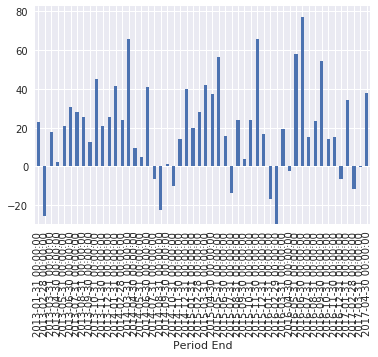

In [54]:
#fig, axes = plt.subplots(nrows=1, ncols=4)

# for i, ax in enumerate(axes.reshape(-1)):
#     bos.plot(x='Median Sale Price Residual',y=thing[i],kind='scatter',ax=ax,figsize=(18,18))

prediction_error(df_orig,target,y_pred_trend).plot(kind='bar')#,ax=ax)
# prediction_error(df_orig,target,y_pred_trend_seas).plot(kind='bar',ax=ax)
#prediction_error(df_orig,target,y_pred_trend_seas_add).plot(kind='bar')
#prediction_error(df_orig,target,y_pred_trend_seas_perf).plot(kind='bar',ax=ax)

# Stats Model ARIMA

In [336]:
import warnings
#warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [337]:
p = q = range(0,15)
d = range(0,3)
pdq = list(itertools.product(p,d,q))
sp = sq = range(0,2)
sd = range(0,2)
s = 12
seasonal_pdq = [(x[0],x[1],x[2],s) for x in list(itertools.product(sp,sd,sq))]

In [338]:
# #ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:121.59367522968692
# #warnings.filterwarnings("ignore") # specify to ignore warning messages
# results_list = []

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(bos_arima['Median Sale Price'],
#                                             order=param,
#                                             #seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             results_list.append((param, param_seasonal, results.aic))
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             print('FAILED ARIMA{}x{}12'.format(param, param_seasonal))
#             continue

In [340]:
# #best pdq
# results_df = pd.DataFrame(results_list)
# #best pdq
# results_df.iloc[results_df[2].idxmin()]

In [342]:
#results_df.to_csv('ARIMA_gridsearch.csv',index=False)

# RMSE of Baselines and Standard ARIMA:

### These values depend on the range of values predicted obviously, predictions from 2016-01

1. Simple Trend and Trend+Seasonality
    - Trend: __416 RMSE__
    - Trend+MeanResid: __? RMSE__ 
    - Trend+Seasonality: __374 RMSE__ 
    - Trend+Seasonality+Additional: __146 RMSE__ 
2. ARIMA and SARIMA
    - ARIMA: __342 RMSE__ (1,2,13) and (13,2,1)
    - ARMA: __299 RMSE__ (16,0,1)
    - ARIMA+Additional: __? RMSE__ <-- Need o try this
    - SARIMA: __196 RMSE__ (13,1,1)(1,1,1,12)

In [114]:
#param = (1,2,13) #gridsearched: 1,2,13
param = (16,0,1)
#param_seasonal = (1,1,1,12)
mod = sm.tsa.statespace.SARIMAX(df_orig['Boston, MA Condo/Co-op Median Sale Price'],
                                order=param,
 #                               seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

/opt/conda/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [113]:
y = df_orig['2016':]['Boston, MA Condo/Co-op Median Sale Price']
arima_pred = results.predict(start=pd.to_datetime('2016-01-31'),dynamic=False)
np.sqrt((y-arima_pred)**2).sum()

381.27870525532205

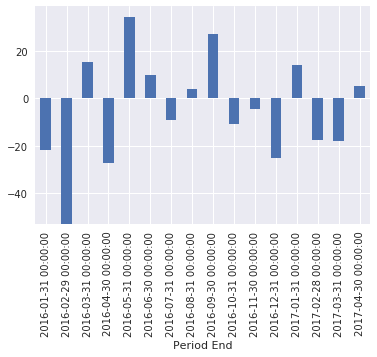

In [110]:
prediction_error(df_orig,target,arima_pred).plot(kind='bar')

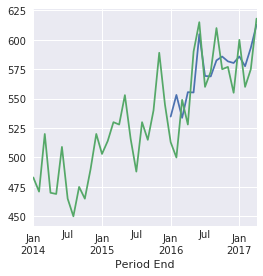

In [111]:
results.predict(start=pd.to_datetime('2016-01-31'),dynamic=False).plot()
(df_orig['2014':]['Boston, MA Condo/Co-op Median Sale Price']).plot(figsize=(4,4))

# Finding optimal params for ARIMA

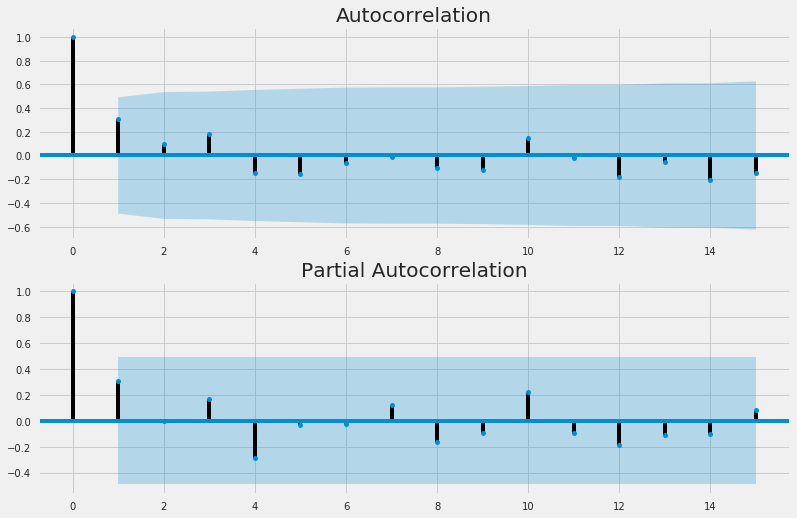

In [433]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_orig['2016':]['Boston, MA Condo/Co-op Median Sale Price'], lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_orig['2016':]['Boston, MA Condo/Co-op Median Sale Price'], lags=15, ax=ax2)